# task 2.1

Consider the same situation of tasks 1.1 and 1.2 in assignment 1, but with the additional possibility of ‘faulty measurements’ in the following sense: with a probability $\gamma$ the sensor returns something meaningless, i.e., with probability $\gamma$ $e_t$ is so that $y_t = 100$. With probability $1 - \gamma$, instead, the sensor works fine and thus the same probabilistic model for generating $e_t$ applies. Note: the outlier events are i.i.d., i.e., the fact that one has an outlier at time $t$ does not modify the probability of having an outlier also at time $t+1$.

In [13]:
# importing the right packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [7]:
# define the function that creates an arbitrary polynomial
# that we will use also to create the scalar quadratic
# 'true model'
#
# note that this function uses both 'lambda functions' and
# the 'enumerate' function -- two features of python
def arbitrary_poly(theta):
    noiseless_y = lambda x: sum([p*(x**i) for i, p in enumerate(theta)])
    return noiseless_y

In [8]:
# Non-random generation between code executions.
# Comment out if you want to repeat the same experiment over and over again
# np.random.seed(123)

In [30]:
# define the function for the mixture distribution
def noise(gamma, alpha, beta, sigma, N):
    
    # generate the noises as before
    if np.random.uniform() < alpha:
        noise = np.random.normal(0, sigma, N)
    else:
        noise = np.random.laplace(0, beta, N)

    # use \infty as a placeholder for the iid events 'faulty measurement'
    for i in range(N):
        if np.random.uniform() < gamma:
            noise[i] = np.inf
    
    return noise

# task 2.2

With respect to assignment 1, though, modify the $u_t$'s so to be \textbf{201} uniformly spaced values in $[-3, 3]$, and set $\alpha = 0$ so that we have Laplacian noises (more precisely, with scale $\beta = 1$). Keep the "true model" quadratic.

In [10]:
# for readability
min_u = -3
max_u = 3
N     = 201 # number of samples

# create the u_t's
u = np.linspace(min_u, max_u, N)

# set the required parameters
beta  = 1
sigma = 1
alpha = 0

# task 2.3

Code again both the LS and ML estimators, but this time add the possibility of testing 3 different model structures: affine, quadratic and cubic models (note: this means that you will have to solve not only the parameters estimation problem, but also the model order selection problem).

In [40]:
# define the function solving the LS problem asked in the assignment
def LS_solver( u, y, model_order ):

    # create the features matrix
    U = u[:, np.newaxis] ** np.arange( model_order )

    # compute the LS estimate by directly solving the normal equations
    theta_hat = np.linalg.solve(U.T @ U, U.T @ y)

    return theta_hat

In [14]:
# define the Laplacian log likelihood function
#
# note that here "x" stands for "theta"
def laplace_log_likelihood(x, u, y):
    
    # this parameter is fixed by the problem formulation 
    scale = 1
    
    # initialization of the returned value
    negative_log_likelihood = 0
    
    # cycle on all the samples
    for j, current_u in enumerate(u):
    
        # for readability
        modelled_y = sum([theta_i * (current_u ** i) for i, theta_i in enumerate(x)])
        measured_y = y[j]
    
        # compute the actual likelihood per sample
        negative_log_likelihood -= (
              np.log(
                        (1.0/(2.0 * scale))
                      * np.exp( -np.abs(modelled_y - measured_y) / scale )
                    ) )

    return negative_log_likelihood

In [93]:
# define the function solving the ML problem asked in the assignment
def ML_solver( u, y, model_order ):

    # compute the ML estimate by directly minimizing the log likelihood
    opt_res = optimize.minimize(
                fun     = laplace_log_likelihood,
                x0      = np.zeros( model_order ),
                args    = (u, y),
                options = {'disp': False} )

    # save the result in a more readable format
    theta_hat = opt_res.x
    
    # debug
#    print('estimated parameters = ', theta_hat)
    
    return theta_hat

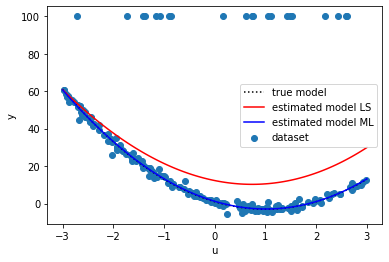

In [94]:
# DEBUG
# check that everything works

# set the parameters
theta_true = [1, -8, 4]
gamma      = 0.1
guessed_model_order = 4

# create the noisy dataset
noiseless_y = arbitrary_poly(theta_true) # use the lambda function
y = noiseless_y( u ) + noise( gamma, alpha, beta, sigma, len(u) )
#
# remember to account for the 'faulty measurements'!
y[np.isinf(y)] = 100

# solve the LS and ML problems
theta_hat_LS = LS_solver( u, y, guessed_model_order )
theta_hat_ML = ML_solver( u, y, guessed_model_order )

# compute the estimated models
modeled_y_LS = arbitrary_poly(theta_hat_LS) # use the lambda function
modeled_y_ML = arbitrary_poly(theta_hat_ML) # use the lambda function

# plot the true model against the measurements and the estimated model
x = np.linspace(start = min_u, stop = max_u, num = 100)
plt.figure()
plt.scatter(u, y,                  label = 'dataset')
plt.plot(x, noiseless_y(x),  'k:', label = 'true model')
plt.plot(x, modeled_y_LS(x), 'r',  label = 'estimated model LS')
plt.plot(x, modeled_y_ML(x), 'b',  label = 'estimated model ML')
plt.xlabel('u')
plt.ylabel('y')
plt.legend();


# task 2.4

Code the full "model order selection / parameters estimation / predictions performance estimation" paradigm by considering the first third of the dataset as a training set, the second as a test set, and the third as a validation set. As "prediction performance index" consider the sum of the absolute deviations between the actually measured $y_t$'s and the predicted ones $\widehat{y}_t$ (i.e., $\widehat{y}_t = \left[ \widehat{\theta}_0, \widehat{\theta}_1, \widehat{\theta}_2, \ldots \right] \left[ 1, u_t, u_t^2, \ldots \right]^T$ with the $\widehat{\theta}$'s the estimated parameters corresponding to the selected model order). Use the same performance index to solve also the model order selection problem.

In [56]:
# define the dataset
training_u   = u[:66]
training_y   = y[:66]
#
testing_u    = u[67:133]
testing_y    = y[67:133]
#
validating_u = u[134:]
validating_y = y[134:]

In [58]:
# define the performance index for this specific assignment
def performance_index( measured_y, estimated_y ):
    return sum( abs( measured_y - estimated_y ) )

# task 2.5

Create some plots that motivate your model order choice, and comment how this choice is easier / more difficult depending on different values of the outliers probability $\gamma$, and which differences you see between the LS and ML solutions.

In [113]:
def solve_estimation_problems( u, gamma, theta_true, max_model_order ):

    # storage allocation
    PIs_LS = np.zeros( max_model_order )
    PIs_ML = np.zeros( max_model_order )

    # dataset generation
    noiseless_y = arbitrary_poly(theta_true) # use the lambda function
    y = noiseless_y( u ) + noise( gamma, 0, 1, 1, len(u) )
    y[np.isinf(y)] = 100
        
    # define the training and test sets
    training_u   = u[:66]
    training_y   = y[:66]
    testing_u    = u[67:133]
    testing_y    = y[67:133]

    # do the model order selection by inspecting the performance on the test set
    for guessed_model_order in range(1, max_model_order):
        
        # 1) train on the training set
        theta_hat_LS = LS_solver( training_u, training_y, guessed_model_order )
        theta_hat_ML = ML_solver( training_u, training_y, guessed_model_order )

        # 2) create the models
        modeled_y_LS = arbitrary_poly(theta_hat_LS) # use the lambda function
        modeled_y_ML = arbitrary_poly(theta_hat_ML) # use the lambda function

        # 3) predict the test set
        predicted_testing_y_LS = modeled_y_LS(testing_u)
        predicted_testing_y_ML = modeled_y_ML(testing_u)

        # 4) compute the performance indexes on the predictive capabilities on the test set
        PIs_LS[guessed_model_order] = performance_index( testing_y, predicted_testing_y_LS )
        PIs_ML[guessed_model_order] = performance_index( testing_y, predicted_testing_y_ML )
        
    return [ PIs_LS, PIs_ML ]

gamma:       0.0
theta_true:  [ 1.26937418  0.09642599 -0.21051459]
PI_LS[i,j]:  [  0.          88.95400925  79.31149347  73.01595596 809.62363442]
PI_ML[i,j]:  [ 0.         79.50527368 98.21199119 63.00279322 65.36093788]
gamma:       0.0
theta_true:  [ 1.75765956  1.1559441  -1.40405788]
PI_LS[i,j]:  [  0.         557.22953656 381.13566212 113.65846509 833.65661518]
PI_ML[i,j]:  [  0.         579.60689404 409.38404371 107.07964596  94.51940666]
gamma:       0.0
theta_true:  [-1.19628086 -0.91337287  1.3247734 ]
PI_LS[i,j]:  [  0.         502.40005557 355.27581566 256.20644487 116.13885878]
PI_ML[i,j]:  [  0.         474.33379388 326.07096433  76.85443825 192.188593  ]
gamma:       0.25
theta_true:  [ 1.26937418  0.09642599 -0.21051459]
PI_LS[i,j]:  [    0.          2424.20992106  2001.83900955  3902.72200543
 11168.43443202]
PI_ML[i,j]:  [   0.         1642.0082885  1634.1709726  1945.85323146 1692.30286873]
gamma:       0.25
theta_true:  [ 1.75765956  1.1559441  -1.40405788]
PI_LS[i

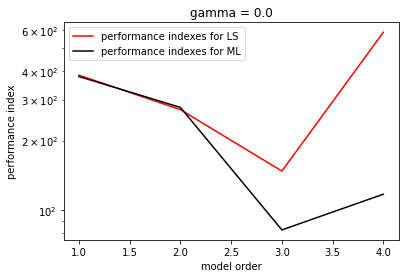

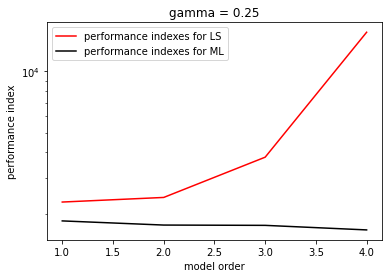

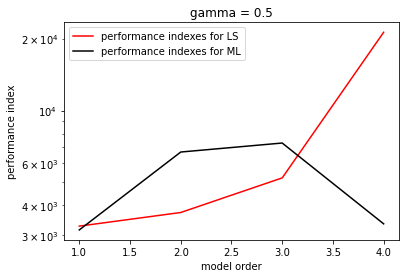

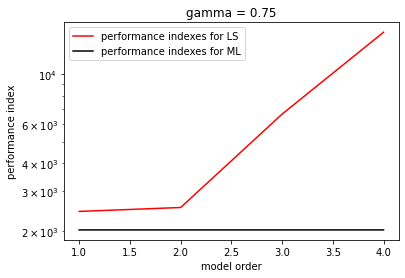

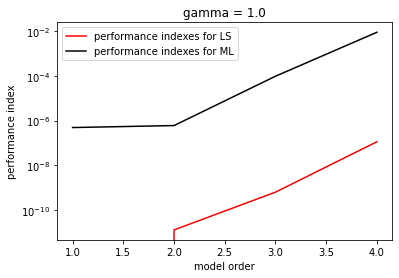

In [122]:
# randomize also on the true models -- storage allocation
n_models        = 3
thetas_true     = np.random.normal(0, 1, size = (n_models, 3))
max_model_order = 5

# storage allocation
# PIs_LS      = np.zeros( n_models )
# PIs_ML      = np.zeros( n_models )

# cycle on the gammas
for i, gamma in enumerate( np.linspace(0, 1, 5) ):
    
    # initialize the values
    mean_PIs_LS = np.zeros( max_model_order )
    mean_PIs_ML = np.zeros( max_model_order )
    
    # cycle on the true models
    for j, theta_true in enumerate(thetas_true):
        
        # compute the PIs
        [ PIs_LS, PIs_ML ] = solve_estimation_problems( u, gamma, theta_true, max_model_order )
                
        # print debug info
        print('gamma:      ', gamma)
        print('theta_true: ', theta_true)
        print('PI_LS[i,j]: ', PIs_LS)
        print('PI_ML[i,j]: ', PIs_ML)
        
        mean_PIs_LS += PIs_LS
        mean_PIs_ML += PIs_ML
    
    # compute the average PIs
    mean_PIs_LS = mean_PIs_LS / n_models
    mean_PIs_ML = mean_PIs_ML / n_models

    # plot the results
    plt.figure(i)
    plt.plot(range(1, max_model_order), mean_PIs_LS[1:max_model_order], 'r', label = 'performance indexes for LS')
    plt.plot(range(1, max_model_order), mean_PIs_ML[1:max_model_order], 'k', label = 'performance indexes for ML')
    plt.xlabel('model order')
    plt.ylabel('performance index')
    #plt.xscale('log')
    plt.yscale('log')
    plt.legend();
    plt.title('gamma = ' + str(gamma))


# task 2.6

Plot the estimated predictive performance capabilities of the LS and ML solutions again as a function of $\gamma$. Compare them and comment the results. Answer the questions: a) Which estimator seems more robust, in average? b) Which estimator is so that its performance degrade least gracefully with increasing $\gamma$?

The plots are as above. ML seems more robust as soon as the number of faulty measurements is meaningfully low. I.e., empirically it seems that for $\gamma < 0.3$ the ML solution is able to reconstruct the underlying function, and the predictive performance in the test set are so that one is also able to select the model order in a meaningful way. It seems though that the ML estimator degrades less gracefully with increasing $\gamma$. Somehow it seems that the LS solution for high $\gamma$'s starts earlier in returning a model saying 'the underlying function is 100, and when there is a measurement that is different from 100 then that is actually a faulty measurement'. 